             precision    recall  f1-score   support

       -1.0       0.19      0.80      0.31        15
        1.0       0.98      0.70      0.82       172

avg / total       0.91      0.71      0.78       187

(121, 3, 0, 0)
Sensitivity is 1.000
Specificity is 0.000


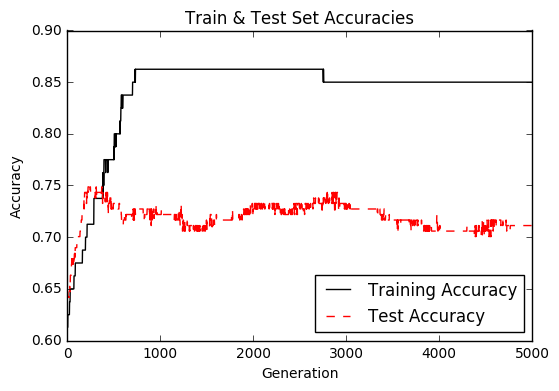

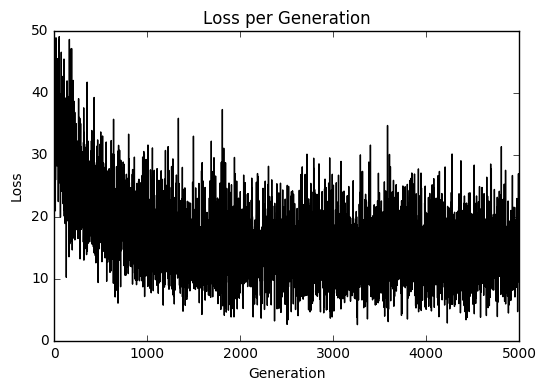

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.python.framework import ops

ops.reset_default_graph()

def extract_data(filename):

    out = np.loadtxt(filename, delimiter=',');

    # Arrays to hold the labels and feature vectors.
    labels = out[:,0]
    labels = labels.reshape(labels.size,1)
    fvecs = out[:,1:]

    # Return a pair of the feature matrix and the one-hot label matrix.
    return fvecs,labels

def formulate_data(filename):

    # Extract data
    data, labels = extract_data(filename)

    # Convert labels {-1, 1}
    tmp  = labels

    labels[labels==0] = -1

    # Get the shape
    size, num_features = data.shape

    return (data, tmp, labels, size, num_features)

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1 
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
        
    print (TP, FP, TN, FN)
        
    return(TP, FP, TN, FN)

def main(argv=None):

    # Get the formulated data & information

    train_data_filename = '../data/SPECT.train.txt'
    test_data_filename = '../data/SPECT.test.txt'
    
    train_data, pr_train_labels, train_labels, train_size, num_features = formulate_data(train_data_filename)
    test_data, pr_test_labels, test_labels, test_size, num_features = formulate_data(test_data_filename)

    # Declare the input
    xData  = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
    yLabels = tf.placeholder(shape=[None, 1], dtype=tf.float32)

    # Create Variables
    W = tf.Variable(tf.random_normal([num_features,1]))
    b = tf.Variable(tf.random_normal([1]))

    # Declare the output
    yRaw = tf.add(tf.matmul(xData, W), b)

    # Model the loss function
    reg_para = tf.constant([0.01])
    svmC = 1
    l2_norm = tf.reduce_sum(tf.square(W))
    classification_term = svmC * tf.reduce_sum(tf.maximum(tf.zeros([40,1]), 
                                                1 - yLabels*yRaw));
    regularization_loss = tf.mul(reg_para, l2_norm)
    loss = tf.add(classification_term, tf.mul(regularization_loss, reg_para))

    # Model the prediction function
    prediction = tf.sign(yRaw)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, yLabels), dtype=tf.float32))

    # Model the optimizer
    # learning_rate = tf.constant([0.001])
    learning_rate = 0.0005
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Define training parameters
    batch_size = 40
    train_epochs = 5000

    with tf.Session() as sess:

        # Initialize all variables
        init = tf.global_variables_initializer()
        sess.run(init)

        # Define metric parameters
        loss_vec = []
        train_accuracy = []
        test_accuracy = []

        # Training
        for epoch in xrange(train_epochs):

            # Randomize batch
            rand_index = np.random.choice(len(train_data), size=batch_size)
            rand_x = train_data[rand_index]
            rand_y = train_labels[rand_index]
            sess.run(optimizer, feed_dict={xData: rand_x, yLabels: rand_y})

            # Append metric data
            tmp_loss = sess.run(loss, feed_dict={xData: rand_x, yLabels: rand_y})
            loss_vec.append(tmp_loss)

            train_acc_tmp = sess.run(accuracy, feed_dict={xData: train_data, yLabels: train_labels})
            train_accuracy.append(train_acc_tmp)

            test_acc_tmp = sess.run(accuracy, feed_dict={xData: test_data, yLabels: test_labels})
            test_accuracy.append(test_acc_tmp)
        
        predicted = sess.run(prediction, feed_dict={xData: test_data, yLabels: test_labels})
        report = classification_report(test_labels, predicted)
        print(report)
        
        (tp, fp, tn, fn) = perf_measure(test_labels, predicted);
        
        print "Sensitivity is %.3f" % (float(tp) / (tp + fn))
        print "Specificity is %.3f" % (float(tn) / (tn + fp))
        
#         print(test_accuracy[-1])
        
        # Plot train/test accuracies
        plt.plot(train_accuracy, 'k-', label='Training Accuracy')
        plt.plot(test_accuracy, 'r--', label='Test Accuracy')
        plt.title('Train & Test Set Accuracies')
        plt.xlabel('Generation')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

        # Plot loss over time
        plt.plot(loss_vec, 'k-')
        plt.title('Loss per Generation')
        plt.xlabel('Generation')
        plt.ylabel('Loss')
        plt.show()

if __name__ == '__main__':
    main()